# Interacting with Elasticsearch from a Python notebook

In [214]:
# Install the dependencies for the lab
!pip install -qU elasticsearch overturemaps pandas geopandas matplotlib

WORK_DIR="/lab"

## Get the data from Overturemaps Places dataset

In [215]:
import os
places_path = os.path.join(WORK_DIR, "places.parquet")

In [3]:
# Download places (POI) from the Overturemaps parquet release
from overturemaps import core

# Get bounding boxes from http://bboxfinder.com
bosnia_bbox = [15.688477,41.873651,20.489502,45.278752]
valencia_bbox = [-0.432243,39.419221,-0.296288,39.504306]

gdf = core.geodataframe("place",bbox=valencia_bbox)
print(f"{len(gdf)} features downloaded")
gdf.head(1)

# Save the content into a file
gdf.to_parquet(path=places_path)

36193 features downloaded


In [192]:
# If Internet download does not work, read the content from a file
import geopandas as gpd

gdf = gpd.read_parquet(path=places_path)
print(f"{len(gdf)} features downloaded")

36193 features downloaded


In [201]:
# Modify the dataframe to get the data out from the object types
gdf["source"] = gdf["sources"].apply(lambda x: x[0].get("sources",{}).get("dataset",None) if len(x)>0 else None )
gdf["name"] = gdf["names"].apply(lambda x: x.get("names",{}).get("primary", None))
gdf["category"] = gdf["categories"].apply(lambda x: x.get("primary", None))
gdf["alt_categories"] = gdf["categories"].apply(lambda x: x.get("alternate", []))
gdf["brand_"] = gdf["brand"].apply(lambda x: x.get("primary",None) if x else None)

id                             9597ee8e-84c0-4dc3-9395-20a389ba0c59
geometry                                POINT (-0.43221 39.4208799)
bbox              {'xmax': -0.4322099983692169, 'xmin': -0.43221...
version                                                           1
sources           [{'between': None, 'confidence': 0.49293966623...
names             {'common': None, 'primary': 'Naranjas Hort Alb...
categories        {'alternate': ['shopping', 'grocery_store'], '...
confidence                                                  0.49294
websites                       [http://www.naranjasalbagarces.com/]
socials                     [https://www.facebook.com/102986254619]
emails                                                         None
phones                                               [+34961591344]
brand                                                          None
addresses         [{'country': 'ES', 'freeform': 'Camí dels Hort...
source                                          

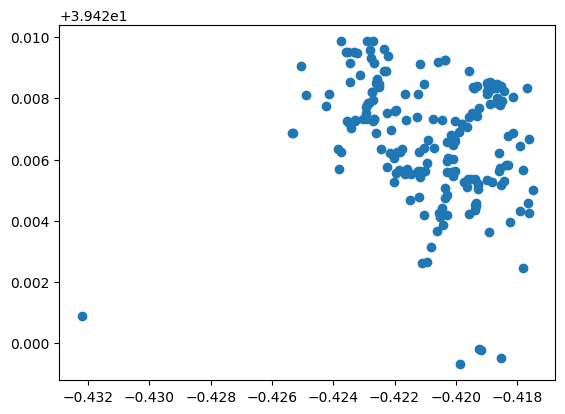

In [213]:
# See the first row and some points on a map
gdf.head(200).plot()
gdf.iloc[0]

## Connect to Elasticsearch

In [5]:
from elasticsearch import Elasticsearch
import os

# Login details
ES_URL=os.getenv("ES_URL","http://elasticsearch:9200")
KB_URL=os.getenv("KB_URL","http://kibana:5601")
ES_PASS=os.getenv("ES_PASS","changeme")
ES_AUTH=("elastic", ES_PASS)

In [6]:
client = Elasticsearch(hosts=[ES_URL], basic_auth=ES_AUTH)

c_info = client.info()
print(f"Cluster name: {c_info['name']}")
print(f"Version: {c_info['version']['number']}")

Cluster name: 367de8788b3e
Version: 9.0.3


In [5]:
from pprint import pprint
c_license = client.license.get()['license']
print(f"License is {c_license.get('status')} and on **{c_license.get('type')}** until **{c_license.get('expiry_date', "N/A")}**")

License is active and on **basic** until **N/A**


In [7]:
# Opt out from trial
if client.license.get_basic_status().get('eligible_to_start_basic',False):
    print("Moving to basic")
    client.license.post_start_basic(acknowledge=True)

c_license = client.license.get().get('license')
print(f"License is {c_license.get('status')} and on **{c_license.get('type')}**")

License is active and on **basic**


## Connect to Kibana

In [8]:
import requests
import json
from functools import partial

kibana_headers = {
    "kbn-xsrf": "true",
    "Content-Type": "application/json"
}
session = requests.Session()
session.auth = ES_AUTH
kib_get = partial(session.get, headers=kibana_headers)
kib_put = partial(session.put, headers=kibana_headers)


In [10]:
# Check the status
r_status = kib_get(f"{KB_URL}/api/status")
r_status_json = r_status.json()
print(f"Kibana {r_status_json['version']['number']}: {r_status_json['status']['overall']['summary']}")

Kibana 9.0.3: All services and plugins are available


In [11]:
# Optional: change default space to Search type (simpler UI)
desired_solution = "es"

# Get the default space data
default_space = kib_get(f"{KB_URL}/api/spaces/space/default").json()

# If a solution is not defined or the desired, change it
solution = default_space.get("solution", False) 
if solution != desired_solution:
    payload = {
        "id": default_space["id"],
        "name": default_space["name"],
        "solution": desired_solution
    }
    
    # Modify the Space with the new solution
    r_space = kib_put(
        f"{KB_URL}/api/spaces/space/default",
        data=json.dumps(payload)
    )
    r_space_json = r_space.json()
    print(f"Space is now a '{r_space_json.get("solution")}' type")
else:
    print("Space is already a search type")

Space is already a search type


## Upload the dataset

In [185]:


# Generator funcion to yield documents to upload to ES
def generate_actions():
    for index, doc in gdf.iterrows():
        yield {
            "_index": index_name,
            "_id": doc["id"],
            "_source": {
                "id": doc["id"],
                "geometry": str(doc["geometry"]),
                "version": doc["version"],
                "source": doc["source"],
                "name": doc["name"],
                "category": doc["category"],
                "alt_categories": doc["alt_categories"],
                "brand": doc["brand_"],
                "socials": doc["socials"],
                "emails": doc["emails"],
                "phones": doc["phones"],
                "addresses": doc["addresses"]
            }
        }

In [186]:
# Check if the places index exists and remove it
index_name = "places"

# Define the mappings
index_body = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "id": {"type": "text"},
            "geometry": {"type": "geo_point"},
            "version": {"type": "integer"},
            "source": {"type": "keyword"},
            "confidence": {"type": "float"},
            "name": {"type": "text"},
            "category": {"type": "keyword"},
            "alt_categories": {"type": "keyword"},
            "website": {"type": "text"},
            "socials": {"type": "text"},
            "emails": {"type": "text"},
            "phones": {"type": "text"},
            "brand": {"type": "keyword"},
            "addresses": {
                "properties": {
                    "country": {"type": "keyword"},
                    "freeform": {"type": "text"},
                    "locality": {"type": "keyword"},
                    "postcode": {"type": "keyword"},
                    "region": {"type": "keyword"},
                }
            }
        }
    }
}

In [187]:
from elasticsearch import helpers
import time

# Remove the index if necessary
if client.indices.exists(index=index_name):
    print("Deleting previous index...")
    client.indices.delete(index=index_name)

# Create the index with the correct mappings and properties
client.indices.create(index=index_name, body=index_body)

# Perform the bulk ingestion
print("Starting ingestion...")
start_time = time.time()
success_count, errors = helpers.bulk(
    client,
    generate_actions(),
    stats_only=True
)
end_time = time.time()

print(f"Bulk ingestion completed in {end_time - start_time:.2f} seconds.")
print(f"Successfully indexed: {success_count} documents.")
if errors:
    print(f"Errors encountered: {len(errors)}")
    # print("First few errors:", errors[:5]) # Uncomment to see actual errors

# (Optional) Refresh the index to make documents searchable immediately
# This is usually done for testing/development. For production, rely on refresh_interval.
refresh = client.indices.refresh(index=index_name)
if refresh.get("_shards",{}).get("successful",0) == 1:
    print("Index refresh successful")

Deleting previous index...
Starting ingestion...
Bulk ingestion completed in 2.97 seconds.
Successfully indexed: 36193 documents.
Index refresh successful


In [188]:
# Verify ingestion by searching
print(f"\nVerifying document count in '{index_name}':")
try:
    count_response = client.count(index=index_name)
    print(f"Documents in '{index_name}': {count_response['count']}")
except Exception as e:
    print(f"Error verifying documents: {e}")


print(f"\nSearching for any document in '{index_name}'...")
try:
    response = client.search(
        index=index_name,
        query={"match_all": {}}, # This query matches all documents
        size=1                   # We only want the first document found
    )

    # 5. Process the search results
    if response['hits']['total']['value'] > 0:
        first_hit = response['hits']['hits'][0]
        print("\n--- First Document Found ---")
        print(f"Index: {first_hit['_index']}")
        print(f"ID: {first_hit['_id']}")
        print(f"Score: {first_hit['_score']}")
        print("Source Document:")
        import json
        print(json.dumps(first_hit['_source'], indent=2)) # Pretty print the document source
        print("----------------------------")
    else:
        print("No documents found in the index.")

except Exception as e:
    print(f"Error during search: {e}")


Verifying document count in 'places':
Documents in 'places': 36193

Searching for any document in 'places'...

--- First Document Found ---
Index: places
ID: 9597ee8e-84c0-4dc3-9395-20a389ba0c59
Score: 1.0
Source Document:
{
  "id": "9597ee8e-84c0-4dc3-9395-20a389ba0c59",
  "geometry": "POINT (-0.43221 39.4208799)",
  "version": 1,
  "source": null,
  "name": null,
  "category": "health_food_store",
  "alt_categories": [
    "shopping",
    "grocery_store"
  ],
  "brand": null,
  "socials": [
    "https://www.facebook.com/102986254619"
  ],
  "emails": null,
  "phones": [
    "+34961591344"
  ],
  "addresses": [
    {
      "country": "ES",
      "freeform": "Cam\u00ed dels Horts s/n",
      "locality": "Pica\u00f1a",
      "postcode": "46210",
      "region": null
    }
  ]
}
----------------------------
